In [1]:
from jetstream_hugo.jet_finding import *
from jetstream_hugo.definitions import *
from jetstream_hugo.plots import *
from jetstream_hugo.clustering import *
from jetstream_hugo.data import *
from jetstream_hugo.anyspell import *
from jetstream_hugo.stats import *

import colormaps

%load_ext autoreload
%autoreload 2
%matplotlib inline

/storage/homefs/hb22g102/miniforge3/envs/env11_2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
exp_T = ExtremeExperiment(
    DataHandler("ERA5", "surf", "t", "6H", "all", "JJA", -30, 40, 30, 75, 250, 'hourofyear', {'hourofyear': ('win', 4 * 15)}, None)
)
da_T = exp_T.da

data_handlers = []
for varname in ["u", "v", "s"]:
    dh = DataHandler("ERA5", "plev", varname, "6H", "all", None, -80, 40, 15, 80, [175, 200, 225, 250, 300, 350], reduce_da=False)
    data_handlers.append(dh)
exp = MultiVarExperiment(data_handlers)

all_jets_one_df, where_are_jets, all_jets_one_array, all_jets_over_time, flags = exp.track_jets()
props_as_ds_uncat = exp.props_as_ds(False)
props_as_ds = exp.props_as_ds(True)
da = exp.ds["s"]
time_mask = (da.time.dt.season=="JJA")
props_as_ds = props_as_ds.sel(time=time_mask)
props_as_ds_anoms = compute_anomalies_ds(props_as_ds, "hourofyear", True)

In [28]:
augment_predictors(props_as_ds_anoms[["mean_lat", "mean_lon"]].fillna(0), timescales=[1, 12])

<xarray.DataArray 'predictors' (predictor: 8, time: 23552)> Size: 2MB
array([[ 1.34109,  1.18282,  0.95435, ...,  1.18178,  1.6506 ,  1.1881 ],
       [     nan,      nan,      nan, ...,  0.42493,  0.56248,  0.67054],
       [ 0.3181 ,  1.32528,  1.72434, ..., -0.13365,  2.67887,  1.201  ],
       ...,
       [     nan,      nan,      nan, ..., -0.76462, -0.82997, -0.75541],
       [-1.22944,  0.0971 ,  0.13299, ..., -0.58863, -1.2609 , -1.09235],
       [     nan,      nan,      nan, ..., -1.40448, -1.46078, -1.3985 ]])
Coordinates:
  * time            (time) datetime64[ns] 188kB 1959-06-01 ... 2022-08-31T18:...
  * predictor       (predictor) object 64B MultiIndex
  * varname         (predictor) object 64B 'mean_lat' 'mean_lat' ... 'mean_lon'
  * jet             (predictor) <U11 352B 'subtropical' ... 'polar'
  * timescale       (predictor) int64 64B 1 12 1 12 1 12 1 12
    predictor_name  (predictor) <U23 736B 'mean_lat_subtropical_1' ... 'mean_...

# Visualize clusters

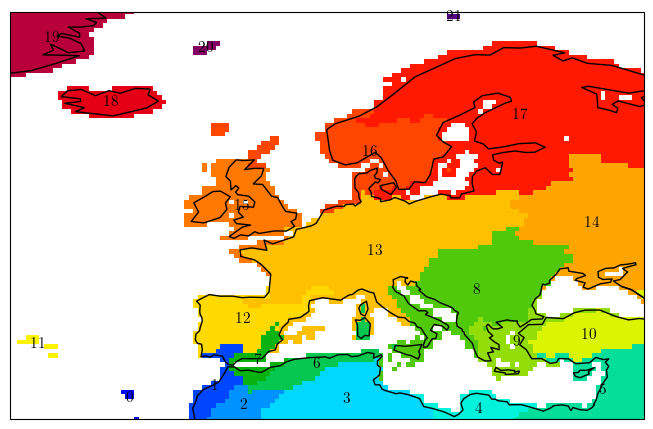

In [7]:
clu = Clusterplot(1, 1, exp_T.region)
cmap = colormaps.BlAqGrYeOrReVi200
ax = clu.axes[0]
unique_clusters = np.arange(n_clu)
norm = BoundaryNorm(np.concatenate([[-1], unique_clusters]) + 0.5, cmap.N)
clusters_da.plot(
    ax=ax,
    cmap=cmap,
    add_colorbar=False,
    add_labels=False
)
for j in range(n_clu):
    lo = clusters_da.lon.where(clusters_da==j).mean().item()
    la = clusters_da.lat.where(clusters_da==j).mean().item()
    ax.text(lo, la, f"${j}$", ha="center", va="center", fontweight="bold")

# Jet indices during heatwaves at region $R$

  0%|          | 0/22 [00:00<?, ?it/s]/storage/homefs/hb22g102/miniforge3/envs/env11_2/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(
100%|██████████| 22/22 [00:32<00:00,  1.50s/it]


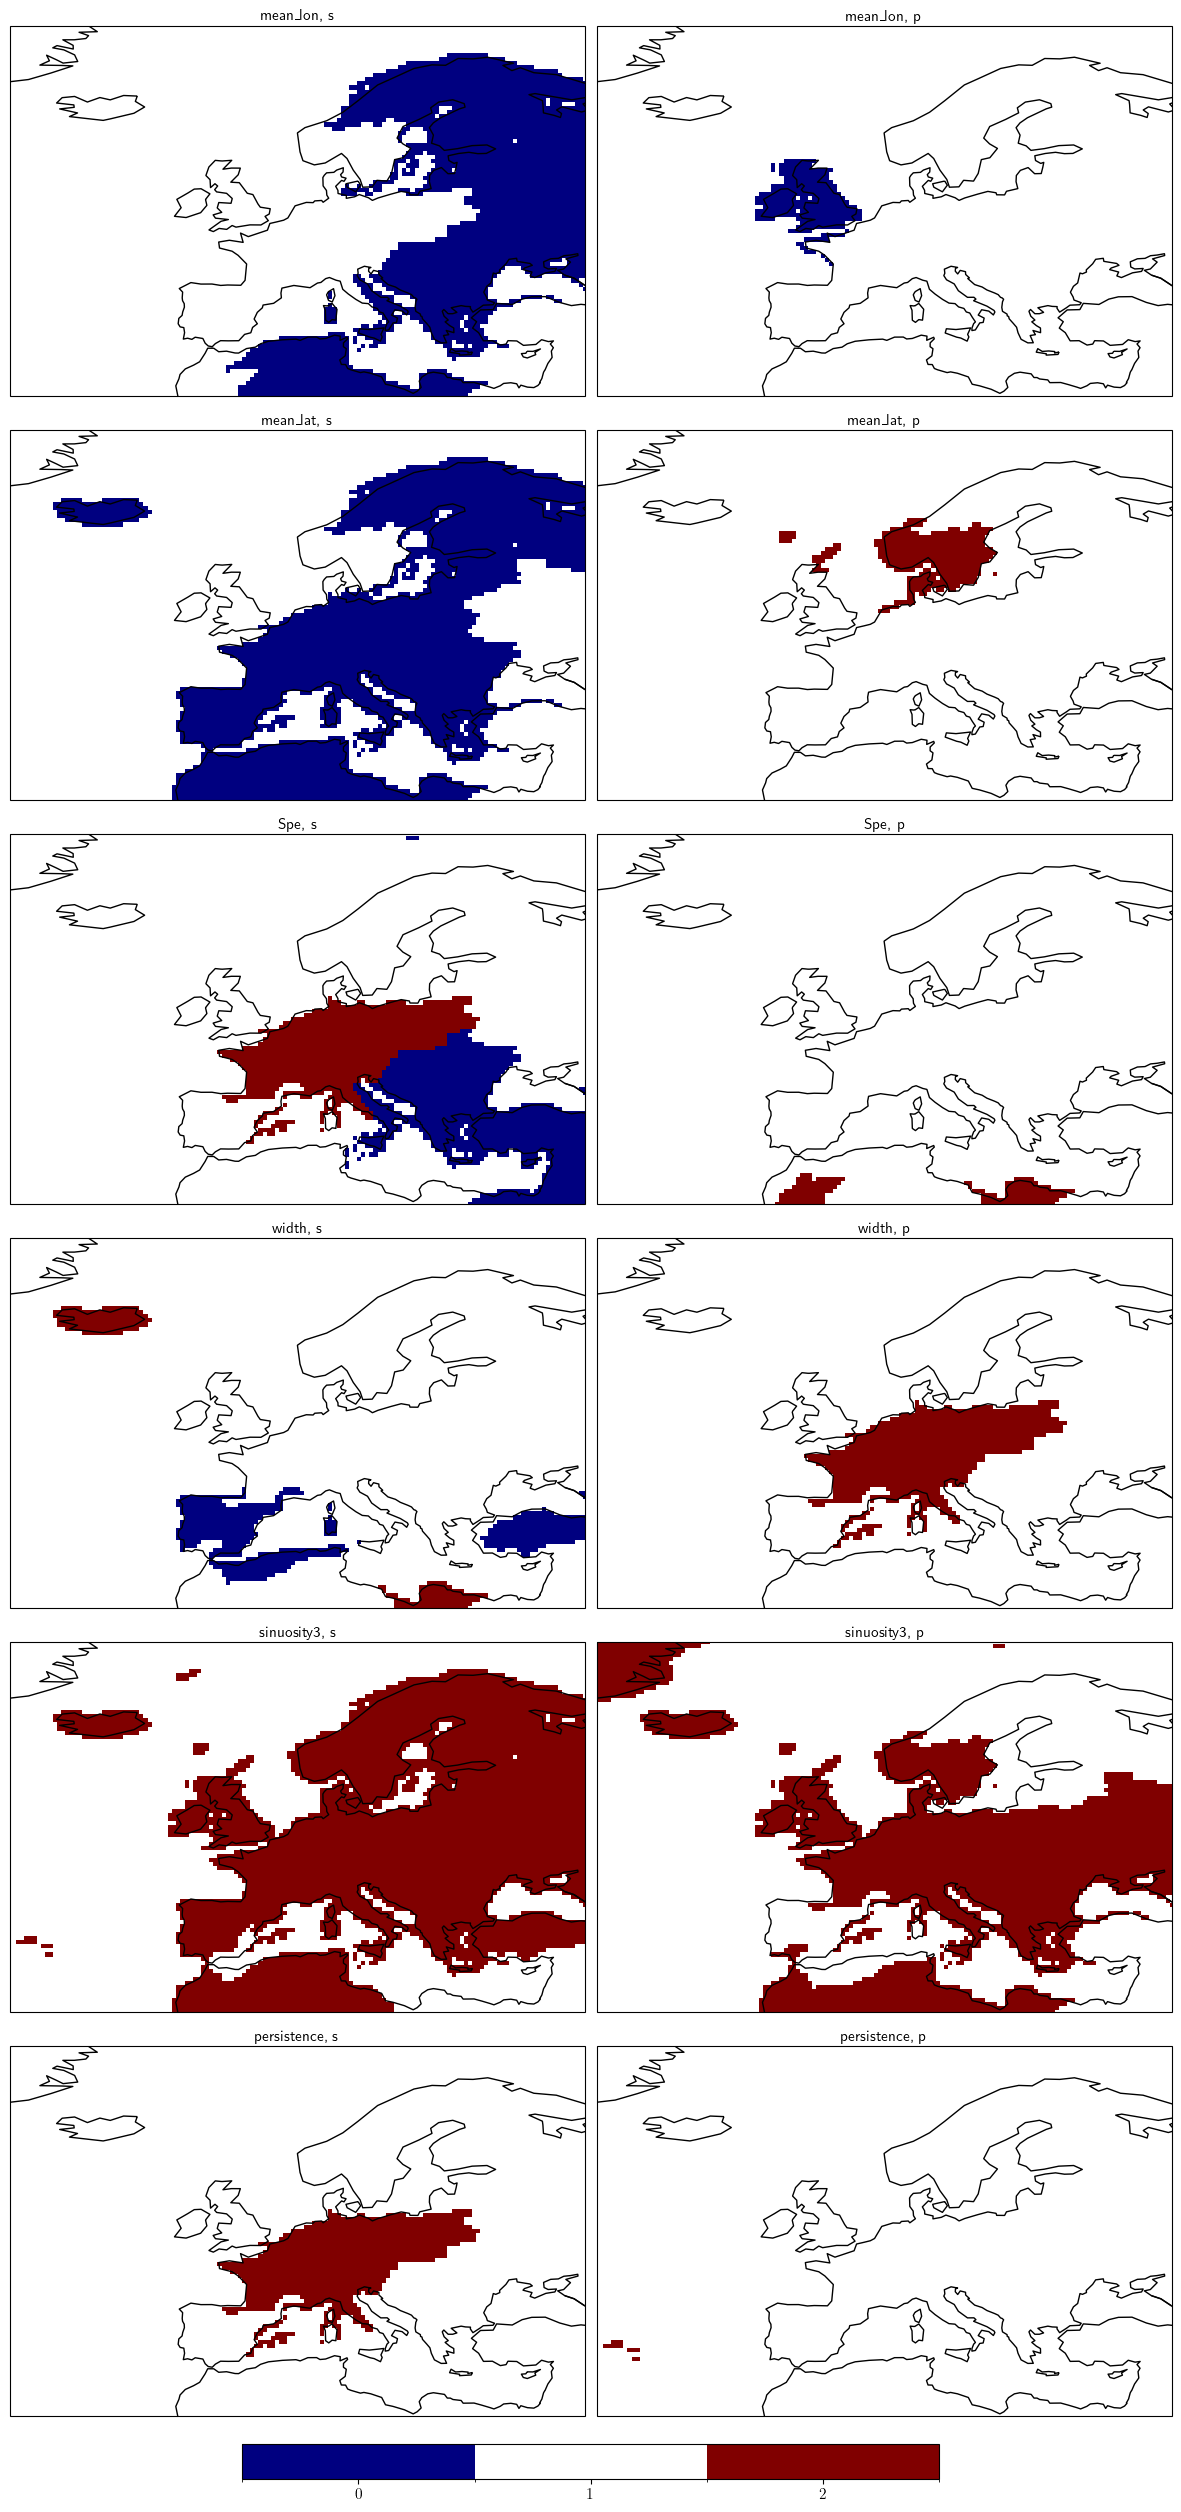

In [11]:
q_hw = 0.95
maxlen = 16
time_before = np.timedelta64(0, "D")

data_vars = ["mean_lon", "mean_lat", "Spe", "width", "sinuosity3", "persistence"]
to_plot = {f"{varname}, {jet[0]}": clusters_da.copy() for varname, jet in product(data_vars, props_as_ds.jet.values)}
props_as_as_subset = props_as_ds[data_vars]
quantiles = props_as_as_subset.quantile([0.33, 0.66], dim="time")
for n in trange(n_clu):
    this_region = clusters_da.where(clusters_da == n).unstack().copy() > 0
    this_da = da_T.where(this_region).mean(dim=["lon", "lat"]).copy()
    try:
        heat_waves_ts, heat_waves, hs_da = heat_waves_from_t(this_da, q=q_hw, minlen=np.timedelta64(4, "D"), time_before=time_before, fill_holes=True, output_type="both")
        props_as_ds_masked = mask_from_heat_waves(this_da, props_as_as_subset, heat_waves_ts, heat_waves, time_before=time_before)
    except (ValueError, KeyError):
        for varname, jet in product(data_vars, props_as_ds.jet.values):
            to_plot[f"{varname}, {jet[0]}"] = to_plot[f"{varname}, {jet[0]}"].where(clusters_da != n)
        continue
    maxlen_ = min(len(props_as_ds_masked.time_around_beg), maxlen)
    props_as_ds_masked = props_as_ds_masked.isel(time_around_beg=slice(maxlen_))
    hw_means = props_as_ds_masked.mean(dim=["heat_wave", "time_around_beg"])
    for varname, jet in product(data_vars, props_as_ds.jet.values):
        val = np.searchsorted(quantiles[varname].sel(jet=jet).values, hw_means[varname].sel(jet=jet).values)
        to_plot[f"{varname}, {jet[0]}"] = to_plot[f"{varname}, {jet[0]}"].where(clusters_da != n, val)
clu = Clusterplot(len(data_vars), 2, exp_T.region)
cmap = colormaps.BlWhRe
norm = BoundaryNorm(np.arange(-0.5, 3.5), cmap.N)
clu.fig.colorbar(ScalarMappable(norm, cmap), ax=clu.axes, shrink=0.6, ticks=[0, 1, 2], orientation="horizontal", pad=0.01)
for ax, (varname, jet) in zip(clu.axes.ravel(), product(data_vars, props_as_ds.jet.values)):
    key = f"{varname}, {jet[0]}"
    to_plot[key].plot(ax=ax, cmap=cmap, norm=norm, add_colorbar=False, add_labels=False)
    ax.set_title(key, pad=4)
clu.resize_relative([0.9, 1.0])

# Prepare for GB like 

In [8]:
subset = ["mean_lon", "mean_lat", "mean_lev", "Spe", "tilt", "sinuosity3", "width", "int", "int_over_europe", "persistence", "com_speed"]
props_as_ds_anoms_ = props_as_ds_anoms[subset]
props_as_ds_ = props_as_ds[subset]
props_as_ds_detrended = props_as_ds_.copy()
for varname in subset:
    props_as_ds_[varname] = props_as_ds_[varname].interpolate_na("time", method="nearest", fill_value="extrapolate")    
    props_as_ds_detrended[varname] = xrft.detrend(props_as_ds_[varname], dim='time', detrend_type='linear')
predictors = list(product(props_as_ds_anoms_.data_vars, [0, 1]))

/storage/homefs/hb22g102/miniforge3/envs/env11_2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
q_hw = 0.8
time_before = np.timedelta64(0, "D")

y_base = xr.DataArray(np.zeros((len(da_T.time), n_clu)), coords={"time": da_T.time.values, "clu": np.arange(n_clu)})
y_pred = y_base.copy()
y_pred = y_pred.assign_coords(
    f1_score=("clu", np.zeros(n_clu)),
    roc_score=("clu", np.zeros(n_clu)),
    accuracy=("clu", np.zeros(n_clu)),
    brier_score_loss=("clu", np.zeros(n_clu)),
)

y_diff = y_base.copy()
for n in trange(n_clu):
    this_region = clusters_da.where(clusters_da == n).unstack().copy() > 0
    this_da = da_T.where(this_region).mean(dim=["lon", "lat"]).copy()
    try:
        _, _, y = heat_waves_from_t(this_da, q=q_hw, minlen=np.timedelta64(4, "D"), time_before=time_before, fill_holes=True, output_type="both")
    except ValueError:
        print(n)
        continue
    y = y > 0
    y_base[:, n] = y
    X_base = (
        (y.time.values - y.time.values[0])
        .astype("timedelta64[h]")
        .astype(int)[:, None]
    )
    y = y.values
    X_train, X_test, y_train, y_test = train_test_split(X_base, y, test_size=0.1)
    lr = LogisticRegression(class_weight=None).fit(X_train, y_train)
    y_pred_prob = lr.predict_proba(X_test)[:, 1]
    pred = lr.predict(X_test)
    y_pred[:, n] = lr.predict_proba(X_base)[:, 1]
    y_pred.roc_score[n] = roc_auc_score(y_test, y_pred_prob)
    y_pred.brier_score_loss[n] = brier_score_loss(y_test, y_pred_prob)
    y_pred.f1_score[n] = f1_score(y_test, pred)
    y_pred.accuracy[n] = balanced_accuracy_score(y_test, pred)

  0%|          | 0/22 [00:00<?, ?it/s]

/storage/homefs/hb22g102/miniforge3/envs/env11_2/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(
  5%|▍         | 1/22 [00:01<00:24,  1.19s/it]

0


100%|██████████| 22/22 [00:36<00:00,  1.67s/it]


# Logistic regression like García-Burgos

In [10]:
from jetstream_hugo.stats import comb_logistic_regression, comb_random_forest
best_combinations = {}
max_n_predictors = 20
for n in range(n_clu):
    combinations = [
        [
            predictor,
        ]
        for predictor in predictors
    ]
    y = y_base[:, n]
    best_combinations[n] = {}
    if not any(y):
        continue
    for n_predictors in trange(1, max_n_predictors):
        coefs, scores = comb_logistic_regression(
            y, props_as_ds_anoms_, combinations
        )
        imax = np.argmax(scores[:, 1])
        best_combinations[n][n_predictors] = (
            scores[imax],
            coefs[imax],
            combinations[imax],
        )
        combinations = [
            [*combinations[imax], predictor]
            for predictor in predictors
            if predictor not in combinations[imax]
        ]


100%|██████████| 19/19 [00:06<00:00,  3.04it/s]


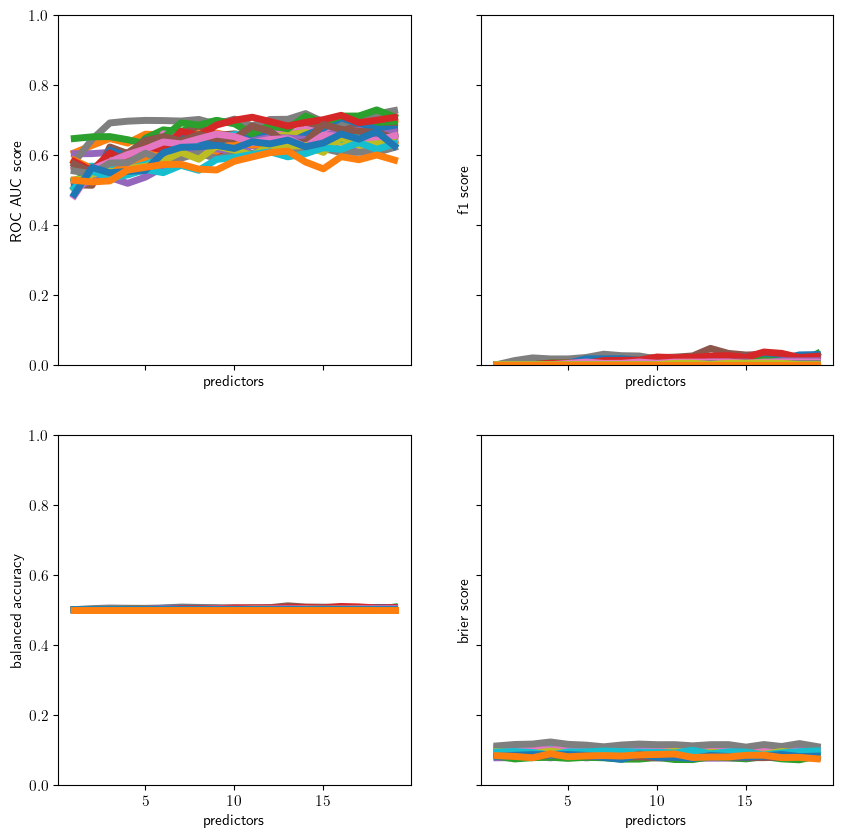

In [13]:
x = np.arange(1, max_n_predictors)
fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharex="all", sharey="all")
titles = ['ROC AUC score', 'f1 score', 'balanced accuracy', "brier score"]
sc = np.zeros((len(titles), n_clu, max_n_predictors - 1))
eb = sc[0].copy()
for n_predictors in x:
    for n in range(n_clu):
        if len(best_combinations[n]) == 0:
            sc[:, n, n_predictors - 1] = np.nan
            eb[n, n_predictors - 1] = np.nan
            continue
        for i, title in enumerate(titles):
            sc[i, n, n_predictors - 1] = best_combinations[n][n_predictors][0][i]
        eb[n, n_predictors - 1] = np.prod(np.exp(np.abs(best_combinations[n][n_predictors][1])))
for i, (ax, title) in enumerate(zip(axes.ravel(), titles)):
    ax.set_xlabel("predictors")
    ax.set_ylabel(title)

    for n in range(n_clu):
        ax.plot(x, sc[i, n, :], label=n, lw=5)
    ax.set_ylim([0., 1])


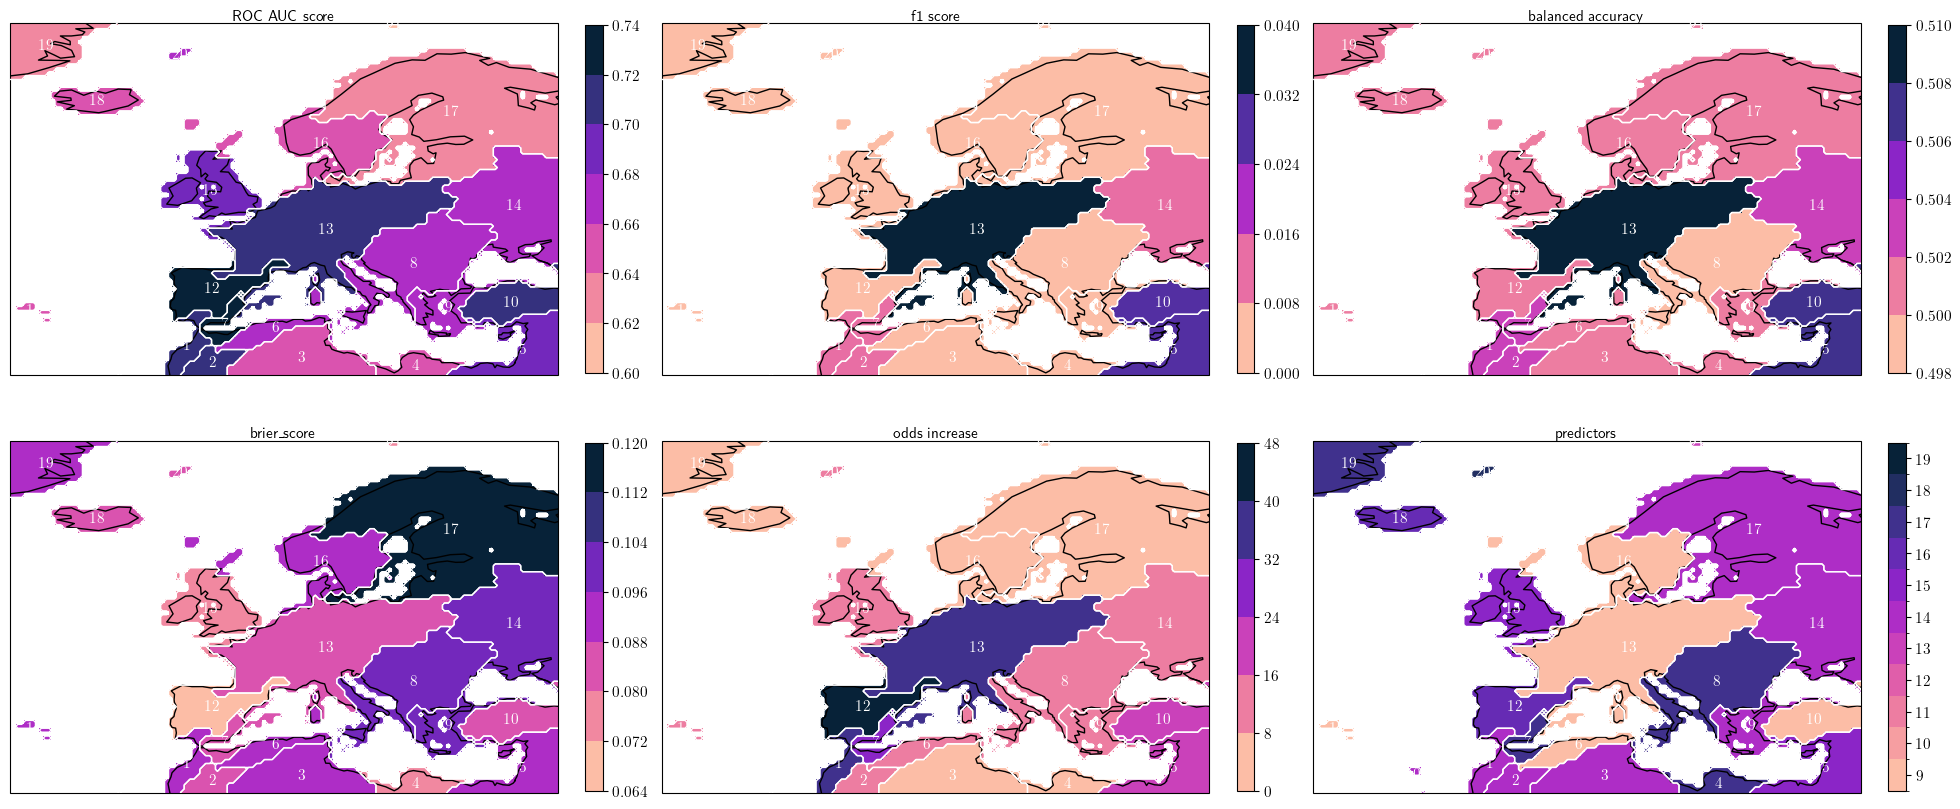

In [15]:
from matplotlib.ticker import MaxNLocator

def assign_to_regions(clusters_da, arr):
    to_ret = clusters_da.copy()
    for i, val in enumerate(arr):
        to_ret = to_ret.where(to_ret != i, val)
    return to_ret 

n_predictors = 1 + np.argmax(sc[0], axis=1)
best_scores = np.take_along_axis(sc, n_predictors[None, :, None] - 1, axis=2).squeeze()
best_eb = np.take_along_axis(eb, n_predictors[:, None] - 1, axis=1).squeeze()
clu = Clusterplot(2, 3, exp_T.region)

for to_plot_, title, ax in zip([*best_scores, best_eb, n_predictors], ['ROC AUC score', 'f1 score', 'balanced accuracy', "brier_score", "odds increase", "predictors"], clu.axes):
    to_plot = assign_to_regions(clusters_da, to_plot_)
    cmap = colormaps.bubblegum_r
    if title == "predictors":
        levels = np.arange(n_predictors[1:].min() - 0.5, n_predictors[1:].max() + 0.6)
        cbar_kwargs = {"shrink": 0.85, "ticks": np.arange(n_predictors[1:].min(), n_predictors[1:].max() + 1)}
    else:
        levels = MaxNLocator(6).tick_values(to_plot.min(), to_plot.max())
        cbar_kwargs = {"shrink": 0.85}
    norm = BoundaryNorm(levels, cmap.N)
    to_plot.plot(ax=ax, cmap=cmap, norm=norm, add_colorbar=True, cbar_kwargs=cbar_kwargs, add_labels=False)
    ax.set_title(title)
    for n in range(n_clu):
        ax.contour(lon, lat, (clusters_da == n).astype(int), colors="white", levels=[0.5], zorder=200, linewidths=1, transform=ccrs.PlateCarree())
        lo = clusters_da.lon.where(clusters_da==n).mean().item()
        la = clusters_da.lat.where(clusters_da==n).mean().item()
        ax.text(lo, la, f"${n}$", ha="center", va="center", fontweight="bold", color="white")

# Same but RF

In [21]:
best_combinations = {}
max_n_predictors = 10


Z = exp_T.heat_wave_linkage()
mask = get_land_mask()
lon, lat = da_T.lon.values, da_T.lat.values
mask = mask.sel(lon=lon, lat=lat)
stack_dims = {'lat_lon': ('lat', 'lon')}
mask_flat = mask.stack(stack_dims)
clusters = cut_tree(Z, n_clusters=n_clu)[:, 0]
clusters_da = np.zeros(mask_flat.shape, dtype=float)
clusters_da[:] = np.nan
clusters_da = mask_flat.copy(data=clusters_da)
clusters_da[mask_flat] = clusters
clusters_da = clusters_da.unstack()

props_as_ds_anoms_ = props_as_ds_anoms[["mean_lon", "mean_lat", "mean_lev", "Spe", "tilt", "sinuosity3", "width", "int", "int_over_europe", "persistence", "com_speed"]]
predictors = list(product(props_as_ds_anoms_.data_vars, [0, 1]))
for n in range(n_clu):
    combinations = [
        [
            predictor,
        ]
        for predictor in predictors
    ]
   
    best_combinations[n] = {}
    y = np.clip(y_base[:, n] - y_pred[:, n], 0, 1)
    if not any(y):
        continue
    for n_predictors in trange(1, max_n_predictors):
        predictor_importance, scores = comb_random_forest_base_rate(
            y, y_pred[:, n], props_as_ds_anoms_, combinations
        )
        imax = np.argmax(scores[:, 1])
        best_combinations[n][n_predictors] = (
            scores[imax],
            predictor_importance[imax],
            combinations[imax],
        )
        combinations = [
            [*combinations[imax], predictor]
            for predictor in predictors
            if predictor not in combinations[imax]
        ]

  0%|          | 0/9 [00:01<?, ?it/s]


ValueError: applied function returned data with an unexpected number of dimensions. Received 2 dimension(s) but expected 1 dimensions with names ('time',), from:

array([[-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       ...,
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.]])

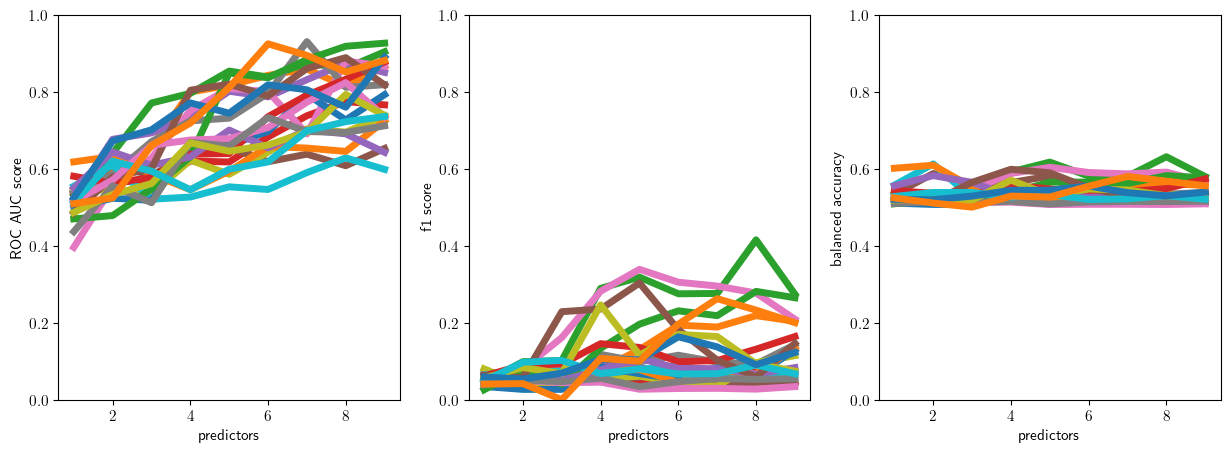

In [7]:
x = np.arange(1, max_n_predictors)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
titles = ['ROC AUC score', 'f1 score', 'balanced accuracy']
sc = np.zeros((len(titles), n_clu, max_n_predictors - 1))
for n_predictors in x:
    for n in range(n_clu):
        if len(best_combinations[n]) == 0:
            sc[:, n, n_predictors - 1] = np.nan
            continue
        for i, title in enumerate(titles):
            sc[i, n, n_predictors - 1] = best_combinations[n][n_predictors][0][i]
for i, (ax, title) in enumerate(zip(axes, titles)):
    ax.set_xlabel("predictors")
    ax.set_ylabel(title)

    for n in range(n_clu):
        ax.plot(x, sc[i, n, :], label=n, lw=5)
    ax.set_ylim([0., 1])


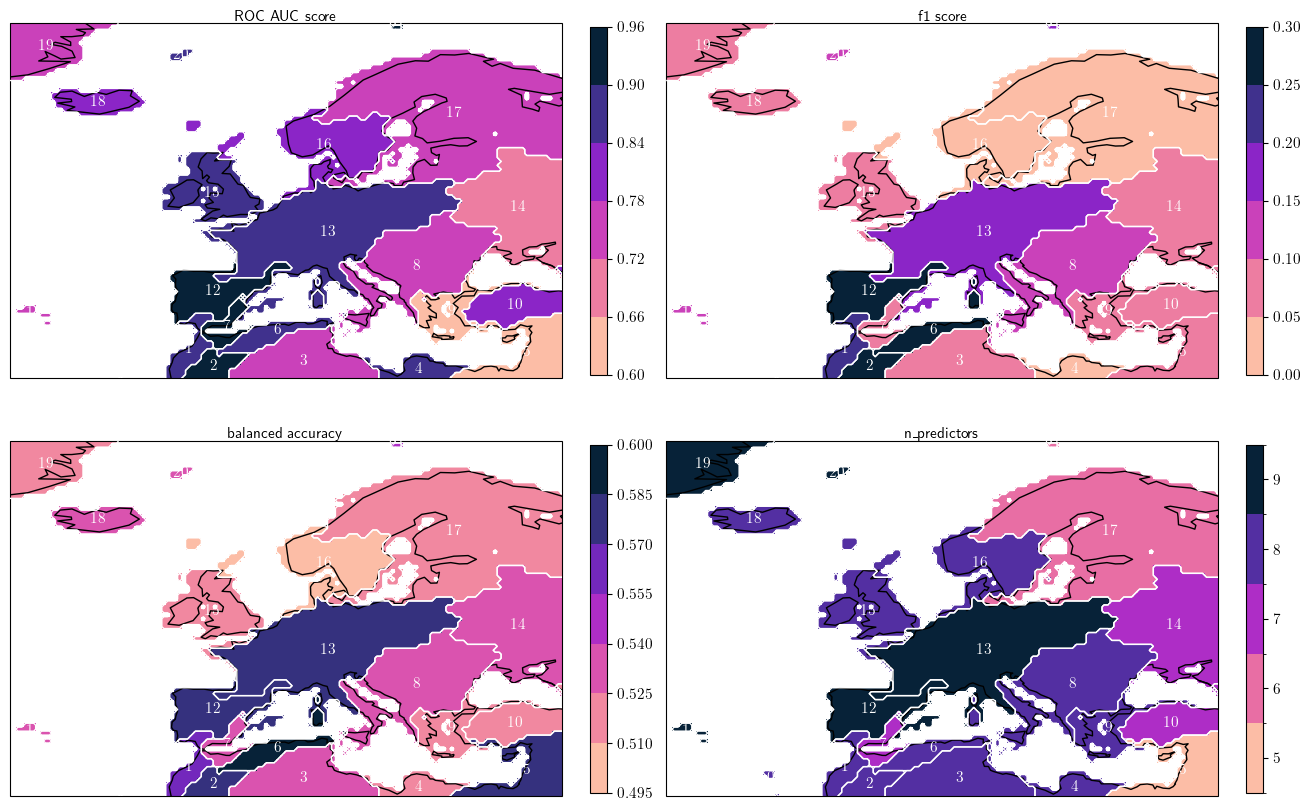

In [68]:
from matplotlib.ticker import MaxNLocator

def assign_to_regions(clusters_da, arr):
    to_ret = clusters_da.copy()
    for i, val in enumerate(arr):
        to_ret = to_ret.where(to_ret != i, val)
    return to_ret 

n_predictors = 1 + np.argmax(sc[0], axis=1)
best_scores = np.take_along_axis(sc, n_predictors[None, :, None] - 1, axis=2).squeeze()
clu = Clusterplot(2, 2, exp_T.region)

for to_plot_, title, ax in zip([*best_scores, n_predictors], ['ROC AUC score', 'f1 score', 'balanced accuracy', "n_predictors"], clu.axes):
    to_plot = assign_to_regions(clusters_da, to_plot_)
    cmap = colormaps.bubblegum_r
    if title == "n_predictors":
        levels = np.arange(n_predictors[1:].min() - 0.5, n_predictors[1:].max() + 0.6)
        cbar_kwargs = {"shrink": 0.85, "ticks": np.arange(n_predictors[1:].min(), n_predictors[1:].max() + 1)}
    else:
        levels = MaxNLocator(6).tick_values(to_plot.min(), to_plot.max())
        cbar_kwargs = {"shrink": 0.85}
    norm = BoundaryNorm(levels, cmap.N)
    to_plot.plot(ax=ax, cmap=cmap, norm=norm, add_colorbar=True, cbar_kwargs=cbar_kwargs, add_labels=False)
    ax.set_title(title)
    for n in range(n_clu):
        ax.contour(lon, lat, (clusters_da == n).astype(int), colors="white", levels=[0.5], zorder=200, linewidths=1, transform=ccrs.PlateCarree())
        lo = clusters_da.lon.where(clusters_da==n).mean().item()
        la = clusters_da.lat.where(clusters_da==n).mean().item()
        ax.text(lo, la, f"${n}$", ha="center", va="center", fontweight="bold", color="white")

In [64]:
jets = props_as_ds.jet.values
for n in range(n_clu):
    if len(best_combinations[n]) == 0:
        continue
    the_best_comb = best_combinations[n][n_predictors[n]]
    sorted_order = np.argsort(the_best_comb[1])[::-1]
    print(f"n = {n}", f"{n_predictors[n]} preds", "scores: ", *[f"{s:.2f}" for s in the_best_comb[0]])
    print()
    for k in sorted_order:
        varname = the_best_comb[2][k][0]
        jet = SHORTHAND[jets[the_best_comb[2][k][1]]]
        importance = the_best_comb[1][k]
        print(f"{varname:>16}", f"{jet:>5}", f"{importance:.1%}")
    print()

n = 1 9 preds scores:  0.87 0.20 0.56

     persistence extra 18.1%
        mean_lat extra 13.0%
        mean_lev extra 12.8%
             int extra 11.6%
     persistence   sub 11.3%
            tilt   sub 9.9%
        mean_lat   sub 9.5%
 int_over_europe   sub 8.4%
             Spe   sub 5.6%

n = 2 9 preds scores:  0.90 0.27 0.58

        mean_lat extra 17.4%
     persistence extra 14.0%
     persistence   sub 11.2%
      sinuosity3 extra 11.2%
             Spe extra 10.7%
        mean_lon   sub 10.2%
             int   sub 9.6%
        mean_lat   sub 8.4%
            tilt   sub 7.4%

n = 3 8 preds scores:  0.77 0.07 0.53

     persistence extra 15.5%
        mean_lon extra 13.8%
      sinuosity3 extra 13.1%
        mean_lev extra 12.4%
            tilt extra 12.4%
             Spe extra 11.4%
             int extra 11.0%
       com_speed extra 10.4%

n = 4 8 preds scores:  0.87 0.05 0.51

     persistence extra 15.8%
            tilt extra 14.6%
        mean_lat extra 13.7%
       

In [51]:
SHORTHAND

{'subtropical': 'sub', 'polar': 'extra'}

In [242]:
from matplotlib.ticker import MaxNLocator
MaxNLocator(7).tick_values(to_plot.min(), to_plot.max())

array([0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 , 0.84, 0.88, 0.92])

# Jet index anoms around heat waves

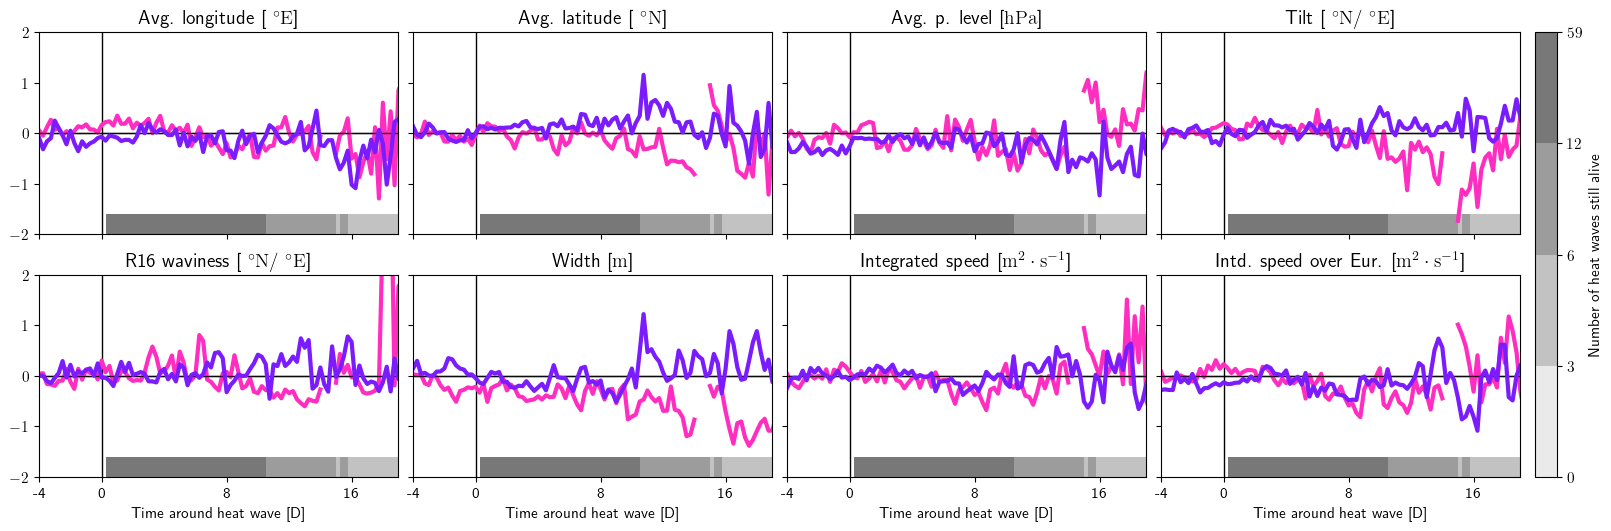

In [17]:
data_vars = ["mean_lon", "mean_lat", "mean_lev", "tilt", "sinuosity3", "width", "int", "int_over_europe"]

fig, axes = plt.subplots(
    2,
    4,
    figsize=(16, len(data_vars) // 4 * 2.6),
    constrained_layout=True,
    sharex="all",
    sharey="all"
)
axes = np.atleast_2d(axes)
months = np.unique(props_as_ds_anoms.time.dt.month.values)
months = [str(months[0]).zfill(2), str(min(12, months[-1] + 1)).zfill(2)]
lengths = heat_waves[:, 1] - heat_waves[:, 0]
longest_hotspell = np.argmax(lengths)
time_around_beg = heat_waves_ts[longest_hotspell] - heat_waves[longest_hotspell, 0]
time_around_beg = time_around_beg.values
dt = (props_as_ds_anoms.time.values[1] - props_as_ds_anoms.time.values[0]).astype("timedelta64[h]")
colors = COLORS[2:0:-1]
n_hotspell = 1
x = props_as_ds_anoms_masked.time_around_beg.values.astype("timedelta64[h]")
for varname, ax in zip(data_vars, axes.ravel()):
    for j, jet in enumerate(props_as_ds_anoms_masked.jet.values):
        this_da = props_as_ds_anoms_masked[varname].loc[..., jet]
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            mean = this_da.mean(dim="heat_wave").values
        ax.plot(x, [0] * len(x), color="black", alpha=0.8, lw=1)
        ax.plot(x, mean, color=colors[j], lw=3, ls="solid")
                
positive_mask = x.astype(int) > 0
alive_hotspells = (~this_da[:, positive_mask].isnull()).sum(dim="heat_wave").values
cmap = colormaps.cet_l_grey_r
cmap = LinearSegmentedColormap.from_list(
    "mod_grey", 
    cmap(np.linspace(0.1, 0.73, 200)), N=200
)
norm = BoundaryNorm([0, 3, 6, 12, alive_hotspells.max()], cmap.N)
indices = [0] + np.arange(16, len(x), 32).tolist()
ticks = x[indices].astype(int)
xlim = np.amin(x.astype(float)), 19 * 24
ticklabels = x.astype("timedelta64[D]").astype(int)[indices]
for varname, ax in zip(data_vars, axes.ravel()):
    ax.set_title(f"{PRETTIER_VARNAME[varname]} [{UNITS[varname]}]", fontsize=14)
    ylim = -2, 2
    ybounds = ylim[0] + np.asarray([0, 0.1 * (ylim[1] - ylim[0])])
    im = ax.pcolormesh(
        x.astype(float)[positive_mask], ybounds, alive_hotspells[None, :-1], zorder=-10, norm=norm,
        cmap=cmap, alpha=0.7
    )
    ax.set_xticks(ticks, ticklabels, ha="center")
    ax.set_xlim(xlim)
    ax.vlines(0, *ylim, color="black", lw=1, ls="solid", zorder=-10)
    ax.set_ylim(ylim)
cbar = fig.colorbar(im, ax=axes, pad=0.01)
_ = cbar.ax.set_ylabel("Number of heat waves still alive")
for ax in axes[-1, :]:
    ax.set_xlabel("Time around heat wave [D]")
plt.savefig(f"{FIGURES}/jet_props_hotspells/jet_props_vs_hotspell_anoms.png")

# Jet index around heat waves

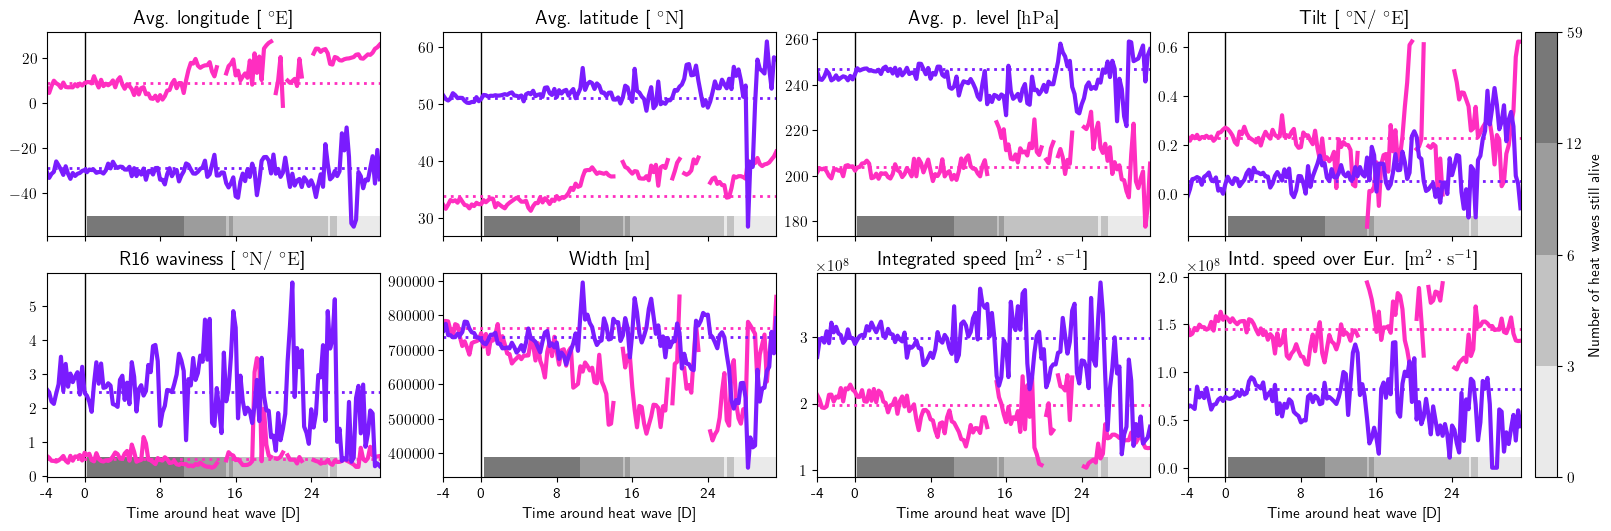

In [18]:
fig, axes = plt.subplots(
    2,
    4,
    figsize=(16, len(data_vars) // 4 * 2.6),
    constrained_layout=True,
    sharex='all'
)
months = np.unique(props_as_ds.time.dt.month.values)
months = [str(months[0]).zfill(2), str(min(12, months[-1] + 1)).zfill(2)]
lengths = heat_waves[:, 1] - heat_waves[:, 0]
longest_hotspell = np.argmax(lengths)
time_around_beg = heat_waves_ts[longest_hotspell] - heat_waves[longest_hotspell, 0]
time_around_beg = time_around_beg.values
dt = (props_as_ds.time.values[1] - props_as_ds.time.values[0]).astype('timedelta64[h]')
colors = COLORS[2:0:-1]
n_hotspell = 1
x = props_as_ds_masked.time_around_beg.values.astype('timedelta64[h]')
for varname, ax in zip(data_vars, axes.ravel()):
    for j, jet in enumerate(props_as_ds_masked.jet.values):
        this_da = props_as_ds_masked[varname].loc[..., jet]
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            mean = this_da.mean(dim='heat_wave').values
        ax.plot(x, mean, color=colors[j], lw=3, ls='solid')
        mean_all = props_as_ds[varname].sel(jet=jet, time=props_as_ds.time.dt.season=="JJA").mean(dim='time').values
        ax.plot(x, [mean_all] * len(this_da.time_around_beg), color=colors[j], lw=2, ls='dotted')
from matplotlib.lines import Line2D

custom_lines = [
    Line2D([0], [0], color='black', lw=2, linestyle='solid', alpha=0.6),
    Line2D([0], [0], color='black', lw=3, linestyle='solid'),
    Line2D([0], [0], color='black', lw=2, linestyle='dotted'),
    Line2D([0], [0], color=colors[0], lw=3),
    Line2D([0], [0], color=colors[1], lw=3),
]
handles = [
    f'{props_as_ds_masked.absolute_time[n_hotspell, 0].dt.year.values} event', f'All heat waves', f'Mean of index',
    'Subtropical jet',
    'Polar jet'
]
positive_mask = x.astype(int) > 0
alive_hotspells = (~this_da[:, positive_mask].isnull()).sum(dim='heat_wave').values
cmap = colormaps.cet_l_grey_r
cmap = LinearSegmentedColormap.from_list(
    'mod_grey', 
    cmap(np.linspace(0.1, 0.73, 200)), N=200
)
norm = BoundaryNorm([0, 3, 6, 12, alive_hotspells.max()], cmap.N)
indices = [0] + np.arange(16, len(x), 32).tolist()
ticks = x[indices].astype(int)
xlim = np.amin(x.astype(float)), np.amax(x.astype(float))
ticklabels = x.astype('timedelta64[D]').astype(int)[indices]
for varname, ax in zip(data_vars, axes.ravel()):
    ax.set_title(f'{PRETTIER_VARNAME[varname]} [{UNITS[varname]}]', fontsize=14)
    ylim = np.asarray(ax.get_ylim())
    ybounds = ylim[[0, 0]] + np.asarray([0, 0.1 * (ylim[1] - ylim[0])])
    im = ax.pcolormesh(
        x.astype(float)[positive_mask], ybounds, alive_hotspells[None, :-1], zorder=-10, norm=norm,
        cmap=cmap, alpha=0.7
    )
    ax.set_xlim(xlim)
    ax.set_xticks(ticks, ticklabels, ha='center')
    ax.vlines(0, *ylim, color='black', lw=1, ls='solid', zorder=-10)
    ax.set_ylim(ylim)
cbar = fig.colorbar(im, ax=axes, pad=0.01)
_ = cbar.ax.set_ylabel('Number of heat waves still alive')
for ax in axes[-1, :]:
    ax.set_xlabel('Time around heat wave [D]')
plt.savefig(f'{FIGURES}/jet_props_hotspells/jet_props_vs_hotspell.png')

# Jet position around heat waves

In [6]:
jet_pos_da = jet_position_as_da(da, props_as_ds_uncat, all_jets_one_df, exp.path, processes=N_WORKERS, chunksize=100)

In [7]:
da_jet_pos_masked = mask_from_t(da_cee, jet_pos_da, q=0.9, fill_holes=True, time_before=pd.Timedelta(4, 'D'))

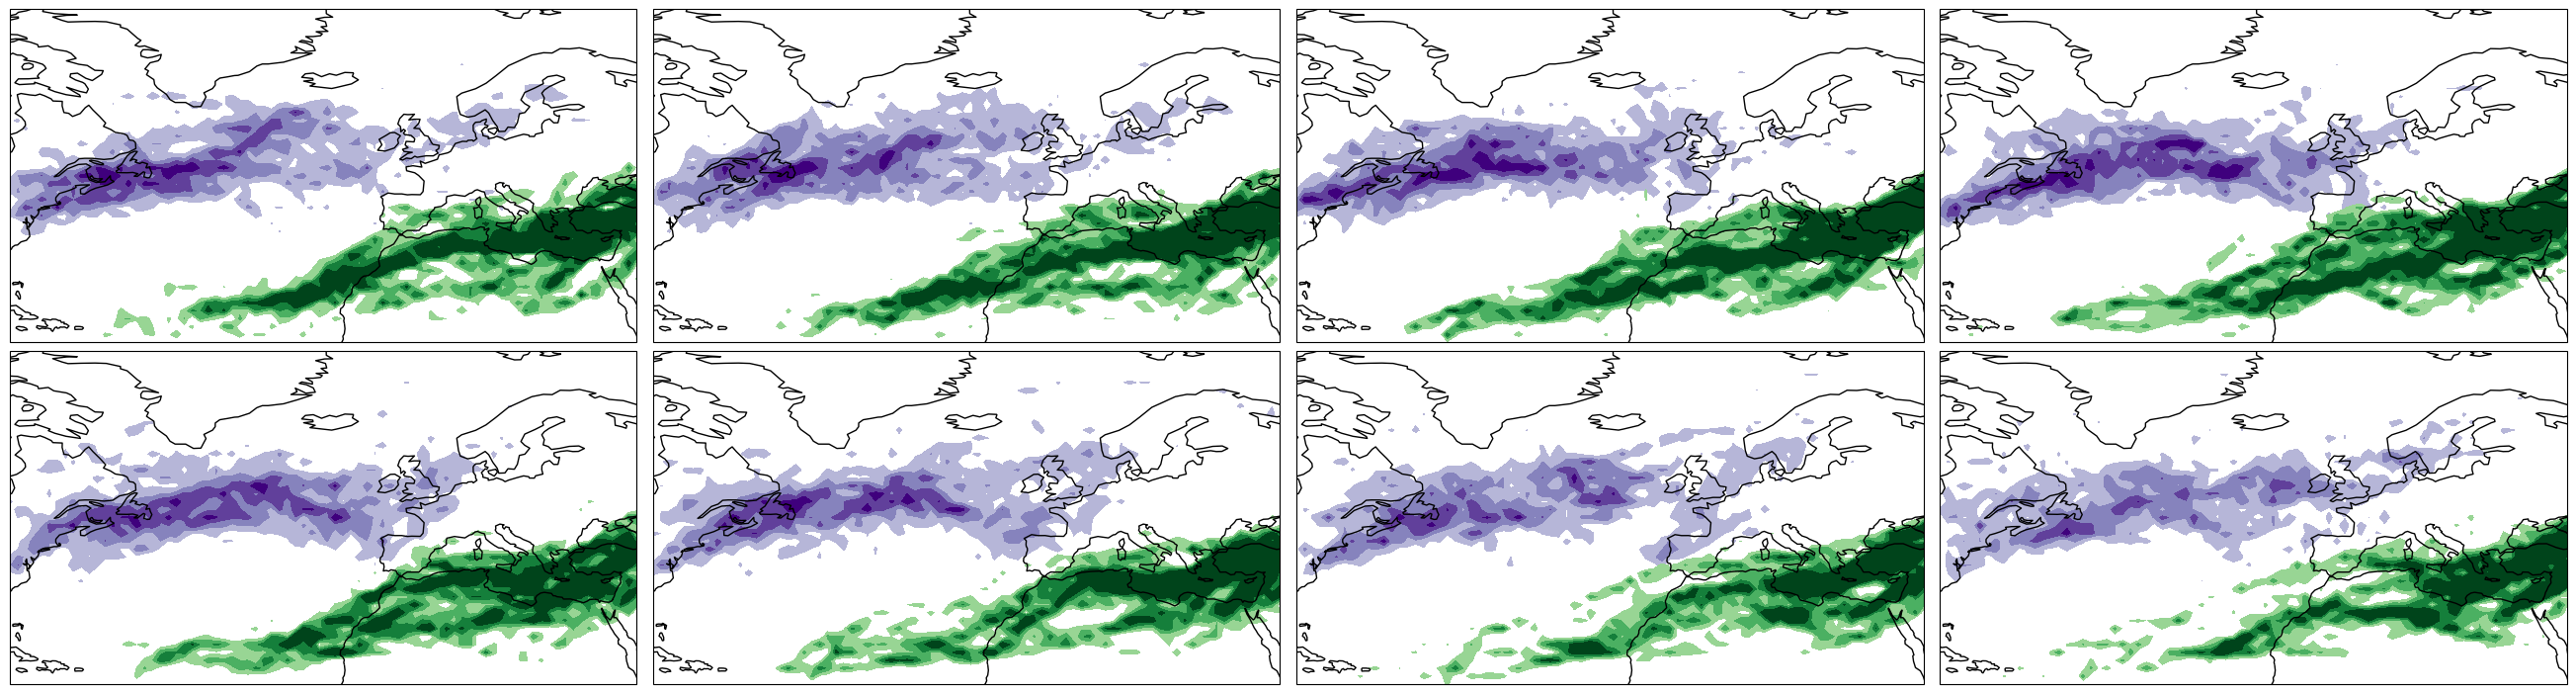

In [24]:
timesteps = np.arange(0, 32)
timesteps = np.arange(0, 32)
timesteps_ = np.split(timesteps, 8)
this_da = da_jet_pos_masked.mean(dim="heat_wave")
to_plot_subtropical = [this_da.isel(time_around_beg=tag, jet=0).mean("time_around_beg") for tag in timesteps_]
to_plot_polar = [this_da.isel(time_around_beg=tag, jet=1).mean("time_around_beg") for tag in timesteps_]
clu = Clusterplot(len(timesteps_) // 4, 4, region=get_region(this_da))
_ = clu.add_contourf(to_plot_polar, cmap='Purples', transparify=2, draw_cbar=False, q=0.95)
_ = clu.add_contourf(to_plot_subtropical, cmap='Greens', transparify=2, draw_cbar=False, q=0.95)
# plt.savefig('/storage/homefs/hb22g102/persistent-extremes-era5/Figures/jet_index_extremes_composites/jet_index_vs_jet_pos.png')